In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm 
from scipy.stats import norm
import matplotlib.pyplot as plt
from src.models import IsotropicGaussian
from src.core import check_intersections

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.probes import generate_custom_probe_set_ext

def load_curves(output_path, n_curves):
    curves_path = output_path + '/curves'
    knots_path = output_path + '/knots'
    curves = [np.loadtxt(curves_path + f'/curve_{i}.txt') for i in range(n_curves)]
    knots = [np.loadtxt(knots_path + f'/knots_{i}.txt') for i in range(n_curves)]
    knots = [np.reshape(k, (len(k) // 2, 2)) for k in knots]
    return curves, knots
    
targets, knots = load_curves('../../stimuli/UNTITLED4', 12)
probes = generate_custom_probe_set_ext(2, ext=.2, plot=False)

In [2]:
data_paths = [
    '../../data/KB_imagery_2024-08-02_12h02.03.323.csv',
    '../../data/H_imagery_2024-08-01_14h30.54.266.csv'
]

dfs = []
for path in data_paths:
    # read in data data
    #data = pd.read_csv('../../data/H_imagery_2024-08-01_14h30.54.266.csv')
    data = pd.read_csv(path)
    data = data.loc[pd.notnull(data.target_file)]
    #print(len(data))

    correct = data.correct_resp
    resp = data['key_resp.keys'].values

    # mark the responses that were correct
    data['acc'] = np.array((resp==correct), dtype=int)
    dfs.append(data)

In [10]:
dfs[1]['key_resp.rt'].mean()

1.8179909913790955

In [4]:
# read in data data
data = pd.read_csv('../../data/KB_imagery_2024-08-02_12h02.03.323.csv')
data = data.loc[pd.notnull(data.target_file)]

correct = data.correct_resp
resp = data['key_resp.keys'].values

# mark the responses that were correct
data['acc'] = np.array((resp==correct), dtype=int)

n_targets = len(list(set(data.target_id.values)))
n_probes = len(list(set(data.probe_id.values)))
n_repeats = len(data[(data.target_id==0) & (data.probe_id==0)])

# compute the accuracy and error tensors
R_img = np.ones((n_targets, n_probes, n_repeats)) * -1
R_vis = np.ones((n_targets, n_probes, n_repeats)) * -1
X_comp = np.ones((n_targets, n_probes, n_repeats)) * -1
X_vis = np.ones((n_targets, n_probes, n_repeats)) * -1

for tid in range(n_targets):
    for pid in range(n_probes):
        d = data[(data.target_id == tid) & (data.probe_id == pid)]
        resps = d['key_resp.keys'].values
        cor = d['correct_resp'].values
        comp = d['comparison'].values
        visn = d['n_isecs'].values
        for i, (r, c) in enumerate(zip(resps, cor)):
            R_img[tid, pid, i] = 1 if r == 'right' else 0
            R_vis[tid, pid, i] = 1 if c == 'right' else 0
            X_comp[tid, pid, i] = comp[i]
            X_vis[tid, pid, i] = visn[i]
            
A = (R_img == R_vis).astype(int)
E = R_img - R_vis

In [5]:
def split_by_complexity(X, n_targets_per_complexity):
    return np.array([X[i:i+n_targets_per_complexity] for i in range(0, len(X), n_targets_per_complexity)])

def compute_SNR(X):
    S = X.mean(axis=2).var(axis=1)
    N = X.var(axis=2).mean(axis=1)
    SNR = S/N
    return SNR.mean()

def compute_d_prime(X, X_hat):
    X = X.flatten()
    X_hat = X_hat.flatten()
    
    n_signal = len(X[X==1])
    n_noise =  len(X[X==0])
    n_hits =  (X_hat[X==1]).sum()
    n_fa =    (X_hat[X==0]).sum()
    
    H = n_hits / n_signal
    F = n_fa / n_noise
    d_prime = norm.ppf(H) - norm.ppf(F)
    return d_prime

In [6]:
avg_error = [e.mean() for e in split_by_complexity(E, 2)]
avg_acc = [a.mean() for a in split_by_complexity(A, 2)]
avg_var = [x.var(axis=2).mean() for x in split_by_complexity(R_img, 2)]
avg_snr = [compute_SNR(x) for x in split_by_complexity(R_img, 2)]

R = list(zip(split_by_complexity(R_vis, 2), split_by_complexity(R_img, 2)))
d_prime = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R]

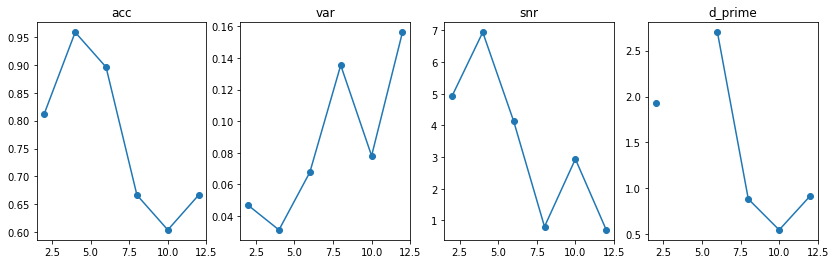

In [7]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)

x = (np.arange(0, 6) * 2) + 2
labels = ['acc', 'var', 'snr', 'd_prime']
for a, y, title in zip(ax, [avg_acc, avg_var, avg_snr, d_prime], labels):

    a.plot(x, y)
    a.scatter(x, y)
    a.set_title(title)

plt.show()

In [8]:
def run_simulation(targets, knots, probes, n_repeats, n_isecs, comparison, tau=7, capacity=2):
    n_targets, n_probes = len(targets), len(probes)
    X = np.ones((n_targets, n_probes, n_repeats)) *-1
    C = np.ones((n_targets, n_probes, n_repeats)) *-1
    R = np.ones((n_targets, n_probes, n_repeats)) *-1
    X_hat = np.ones((n_targets, n_probes, n_repeats)) *-1
    R_hat = np.ones((n_targets, n_probes, n_repeats)) *-1

    for i,(t,k) in tqdm(enumerate(zip(targets, knots))):
        model = IsotropicGaussian(k, capacity, tau)
        sample = model.sample_curves(n_probes*n_repeats)
        for j,p in enumerate(probes):
            n = n_isecs[i, j]
            c = comparison[i, j]
            #_,n = check_intersections(t, p)
            # c = n+.5 if ((i+j)%2 == 0) else n-.5
            r = 1 if n > c else 0
            for k in range(n_repeats):
                X[i, j, k] = n
                C[i, j, k] = c
                R[i, j, k] = r
                _,n_hat = check_intersections(sample[(j*n_repeats) + k], p)
                X_hat[i, j, k] = n_hat
                R_hat[i, j, k] = 1 if n_hat > c else 0
    
    return X, X_hat, R, R_hat


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

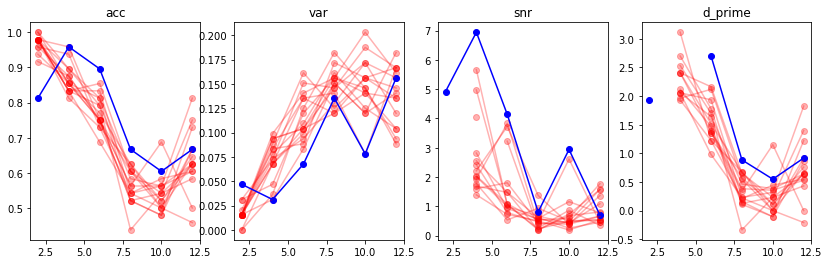

In [9]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)

c = 11
tau = 7
n_samples = 4
alpha = .3

comparison = X_comp[:,:,0]
n_isecs = X_vis[:,:,0]
    
x = (np.arange(0, 6) * 2) + 2
for _ in range(15):
    color='red'
    _,_,R_vis_sim, R_img_sim = run_simulation(targets, knots, probes, n_samples, n_isecs, comparison, capacity=c)
    A_sim = (R_img_sim == R_vis_sim).astype(int)
    E_sim = R_img_sim - R_vis_sim
    avg_error_sim = [e.mean() for e in split_by_complexity(E_sim, 2)]
    avg_acc_sim = [a.mean() for a in split_by_complexity(A_sim, 2)]
    avg_var_sim = [x.var(axis=2).mean() for x in split_by_complexity(R_img_sim, 2)]
    avg_snr_sim = [compute_SNR(x) for x in split_by_complexity(R_img_sim, 2)]

    R_sim = list(zip(split_by_complexity(R_vis_sim, 2), split_by_complexity(R_img_sim, 2)))
    d_prime_sim = [compute_d_prime(r_vis, r_img) for (r_vis, r_img) in R_sim]
    ax[0].plot(x, avg_acc_sim, c=color, alpha=alpha)
    ax[0].scatter(x, avg_acc_sim, c=color, alpha=alpha)
    ax[1].plot(x, avg_var_sim, c=color, alpha=alpha)
    ax[1].scatter(x, avg_var_sim, c=color, alpha=alpha)
    ax[2].plot(x, avg_snr_sim, c=color, alpha=alpha)
    ax[2].scatter(x, avg_snr_sim, c=color, alpha=alpha)
    ax[3].plot(x, d_prime_sim, c=color, alpha=alpha)
    ax[3].scatter(x, d_prime_sim, c=color, alpha=alpha)




ax[0].plot(x, avg_acc, c='b')
ax[0].scatter(x, avg_acc, c='b')
ax[0].set_title('acc')
ax[1].plot(x, avg_var, c='b')
ax[1].scatter(x, avg_var, c='b')        
ax[1].set_title('var')
ax[2].plot(x, avg_snr, c='b')
ax[2].scatter(x, avg_snr, c='b')        
ax[2].set_title('snr')
ax[3].plot(x, d_prime, c='b')
ax[3].scatter(x, d_prime, c='b')
ax[3].set_title('d_prime')


plt.show()

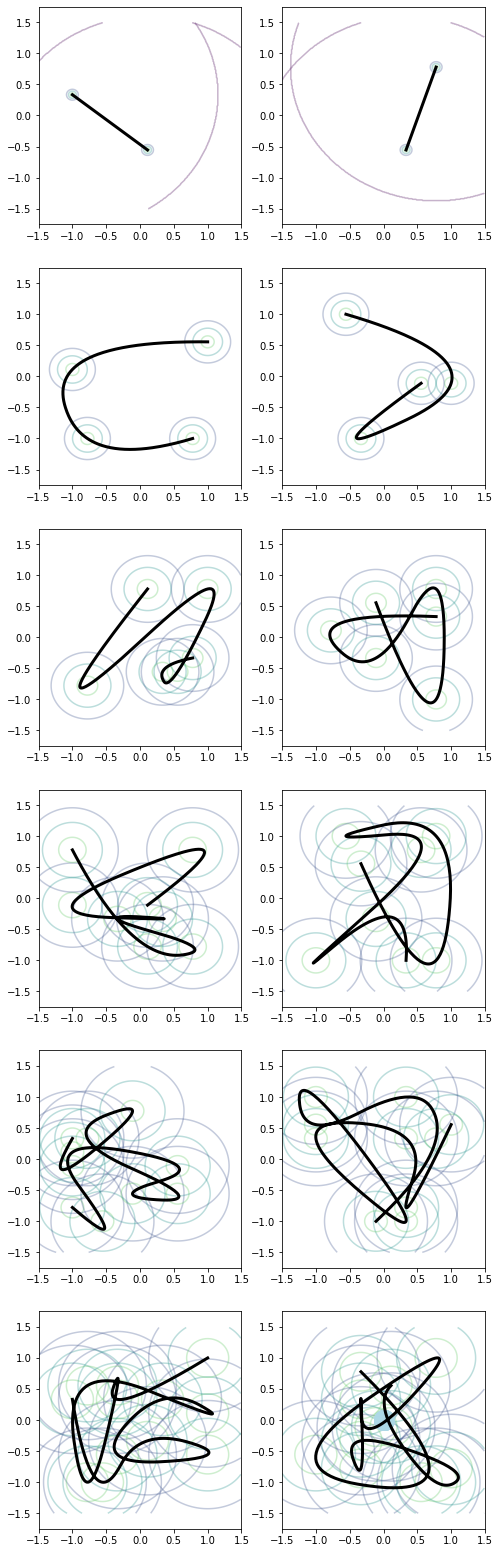

In [27]:
fig, ax = plt.subplots(figsize=(8, 28), ncols=2, nrows=6)
for i,k in enumerate(knots):
    model = IsotropicGaussian(k, c, tau)
    model.visualize(ax[i//2][i%2])

In [18]:
list(set(data[data.target_complexity==2].target_id.values))

[0.0, 1.0]